# 📚 LSTM Code Generation with PyTorch: A Beginner's Guide
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) well-suited for sequence data. In this guide, we'll build an LSTM model in PyTorch to generate text at the word level for programming code. We will walk through the entire process: selecting a dataset, preprocessing text into word tokens, building and training an LSTM model, and finally using it to generate new code. Along the way, we explain the how and why of each step (🤔 why use LSTM? why word-level? etc.). We'll also plot the training loss to visualize learning progress. Let's get started! 🎉

## 🔢 Step 1: Selecting a Programming Code Dataset
Choosing a good dataset is crucial. For code generation, a large corpus of source code is ideal. We go for:

- **CodeSearchNet (GitHub Code Corpus):** A public dataset of code from open-source repositories (available via Hugging Face Datasets). It contains millions of code snippets in various languages and is often used as a starting point for code models. For example, the Python subset of CodeSearchNet would be suitable for learning Python code syntax.


> 💡 Why word-level text? In NLP, one can generate text character-by-character or word-by-word. Word-level generation tends to produce more coherent and meaningful sequences because it treats each whole word (or token) as a unit, maintaining higher-level context than predicting one letter at a time. For code, a "word" is often a token like a keyword (for, if), an identifier (variableName), or a symbol (=). Using word tokens helps the model generate valid identifiers and keywords instead of random characters. (However, note that code has strict syntax; some researchers choose character-level modeling for code to better capture syntax details. In this tutorial we'll use word-level for simplicity and interpretability.)




In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

# Load the Python subset of CodeSearchNet
dataset = load_dataset("code_search_net", "python")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

code_search_net.py:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

The repository for code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code_search_net.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


python.zip:   0%|          | 0.00/941M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

In [ ]:
train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']


## 🔢 Step 2: Data Preparation and Tokenization

In [ ]:
# 🔢 Extract code snippets from the training split
train_data = dataset['train']
code_corpus = ""

# We'll concatenate function code from the dataset into one big string
# Each sample has a 'code' field containing the raw code
for example in train_data.select(range(1000)):
    code_snippet = example['whole_func_string']
    code_corpus += code_snippet + "\n"


In [ ]:
print(train_data[0].keys())


dict_keys(['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'])


In [ ]:
import re

# Remove leading/trailing whitespace
text = code_corpus.strip()

# Replace newline characters with a token (so we know where line breaks were)
text = text.replace("\n", " <NL> ")

# Add spaces around punctuation/special characters for splitting
punctuation = ['(', ')', ':', ',', '%', '!', '"', '+', '=',]
for p in punctuation:
    text = text.replace(p, f" {p} ")

# Split on whitespace to get token list
tokens = text.split()
print(tokens)


['def', 'zmq_device', '(', 'self', ')', ':', '<NL>', "'''", '<NL>', 'Multiprocessing', 'target', 'for', 'the', 'zmq', 'queue', 'device', '<NL>', "'''", '<NL>', 'self.__setup_signals', '(', ')', '<NL>', 'salt.utils.process.appendproctitle', '(', "'MWorkerQueue'", ')', '<NL>', 'self.context', '=', 'zmq.Context', '(', "self.opts['worker_threads']", ')', '<NL>', '#', 'Prepare', 'the', 'zeromq', 'sockets', '<NL>', 'self.uri', '=', "'tcp", ':', '//{interface}', ':', "{ret_port}'.format", '(', '**self.opts', ')', '<NL>', 'self.clients', '=', 'self.context.socket', '(', 'zmq.ROUTER', ')', '<NL>', 'if', "self.opts['ipv6']", 'is', 'True', 'and', 'hasattr', '(', 'zmq', ',', "'IPV4ONLY'", ')', ':', '<NL>', '#', 'IPv6', 'sockets', 'work', 'for', 'both', 'IPv6', 'and', 'IPv4', 'addresses', '<NL>', 'self.clients.setsockopt', '(', 'zmq.IPV4ONLY', ',', '0', ')', '<NL>', 'self.clients.setsockopt', '(', 'zmq.BACKLOG', ',', 'self.opts.get', '(', "'zmq_backlog'", ',', '1000', ')', ')', '<NL>', 'self._start

In [ ]:
# Build vocabulary
vocab = sorted(set(tokens))
vocab_size = len(vocab)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
print(f"Vocabulary size: {vocab_size}")
# Example: print first 10 vocab tokens
print(f"Sample vocab tokens: {list(vocab)[:10]}")


Vocabulary size: 19795
Sample vocab tokens: ['!', '"', '#', '##', "#'.format", "#'save'", '#12.', '#200?', '#2205', '#437']


In [ ]:
# Define sequence length
seq_length = 10

# Convert tokens to their indices
token_indices = [word_to_idx[w] for w in tokens]

# Create input-output pairs
inputs = []
targets = []
for i in range(len(token_indices) - seq_length):
    seq = token_indices[i : i + seq_length]           # N tokens
    target = token_indices[i + seq_length]           # next token
    inputs.append(seq)
    targets.append(target)

# Convert to PyTorch tensors
import torch
inputs = torch.tensor(inputs, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)
print(f"Total training samples: {inputs.shape[0]}")


Total training samples: 255603


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(inputs, targets)
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


## 🔢 Step 3: Designing the LSTM Model (PyTorch)
Now we define our LSTM model for language modeling. The model will have three main parts:
- **Embedding layer:** Converts word indices to dense vectors (learned representations) of a given size.
- **LSTM layer:** Processes the sequence of embeddings and produces hidden states. We can use one or more LSTM layers stacked.
- **Fully-connected output layer:** Maps the LSTM's output to a prediction for the next word (across the vocabulary).

In [ ]:
import torch.nn as nn

class CodeLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=1):
        super(CodeLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Embedding layer: maps token indices to embedding_dim vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer (batch_first means input shape is (batch, seq_len, embed_dim))
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True)
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # x: (batch, seq_length) of token indices
        embeds = self.embedding(x)                # embeds: (batch, seq_length, embedding_dim)
        if hidden is None:
            # If hidden state not provided, initialize to zeros
            # LSTM expects hidden state as a tuple of (h0, c0)
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            hidden = (h0, c0)
        # Run the LSTM
        out, hidden = self.lstm(embeds, hidden)   # out: (batch, seq_length, hidden_size)
        # We only need the LSTM output for the last time step for next-word prediction
        last_out = out[:, -1, :]                  # last_out: (batch, hidden_size)
        logits = self.fc(last_out)                # logits: (batch, vocab_size)
        return logits, hidden

# Define model hyperparameters
embedding_dim = 100
hidden_size = 128
num_layers = 1

model = CodeLSTMModel(vocab_size, embedding_dim, hidden_size, num_layers)
print(model)


CodeLSTMModel(
  (embedding): Embedding(19795, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=19795, bias=True)
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


CodeLSTMModel(
  (embedding): Embedding(19795, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=19795, bias=True)
)

## 🔢 Step 4: Training the LSTM Language Model
With data and model ready, we can train the model to predict next-word tokens.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training hyperparams
num_epochs = 20


In [ ]:
model.train()  # set model to training mode

loss_history = []
for epoch in range(1, num_epochs+1):
    total_loss = 0.0
    for batch_inputs, batch_targets in loader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        # Forward pass
        optimizer.zero_grad()
        logits, _ = model(batch_inputs)            # logits shape: (batch, vocab_size)
        loss = criterion(logits, batch_targets)    # compute cross-entropy loss

        # Backpropagation and update
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
        loss_history.append(avg_loss)
    print(f"Epoch {epoch}/{num_epochs} - Training loss: {avg_loss:.4f}")


Epoch 1/20 - Training loss: 4.2722
Epoch 2/20 - Training loss: 3.2484
Epoch 3/20 - Training loss: 2.7936
Epoch 4/20 - Training loss: 2.4702
Epoch 5/20 - Training loss: 2.2072
Epoch 6/20 - Training loss: 1.9869
Epoch 7/20 - Training loss: 1.7956
Epoch 8/20 - Training loss: 1.6321
Epoch 9/20 - Training loss: 1.4912
Epoch 10/20 - Training loss: 1.3672
Epoch 11/20 - Training loss: 1.2596
Epoch 12/20 - Training loss: 1.1647
Epoch 13/20 - Training loss: 1.0813
Epoch 14/20 - Training loss: 1.0106
Epoch 15/20 - Training loss: 0.9493
Epoch 16/20 - Training loss: 0.8922
Epoch 17/20 - Training loss: 0.8438
Epoch 18/20 - Training loss: 0.8005
Epoch 19/20 - Training loss: 0.7622
Epoch 20/20 - Training loss: 0.7276


## 🔢 Step 5: Visualizing Training Loss 📉
It's often helpful to see the training loss curve. A steadily decreasing loss indicates the model is learning. We will use Matplotlib to plot the epoch vs loss data collected during training.

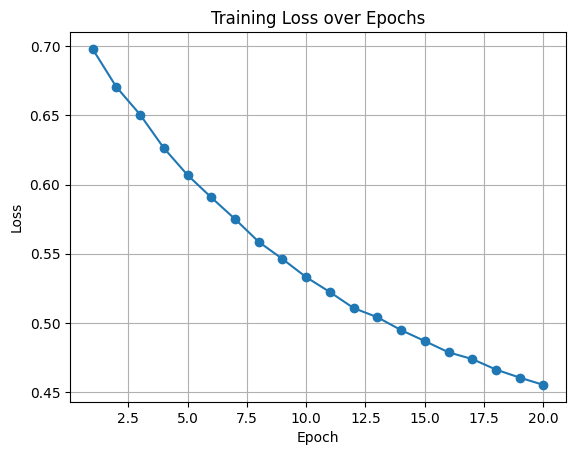

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), loss_history, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


## 🔢 Step 6: Generating Code with the Trained Model


In [ ]:
def generate_code(model, seed_text, generate_length=20):
    model.eval()  # set to eval mode
    words = seed_text.split()
    # Ensure seed words are in vocab; if not, you might skip or map unknowns.
    # We'll assume for simplicity that seed_text words are known.

    # Start with the given seed sequence
    for _ in range(generate_length):
        # Prepare the input tensor for the current last seq_length words
        current_seq = words[-seq_length:]  # take last seq_length words as context
        # Convert to indices, pad if needed
        seq_indices = [word_to_idx.get(w, 0) for w in current_seq]  # (use 0 if out-of-vocab)
        seq_indices = [0]*(seq_length - len(seq_indices)) + seq_indices  # pad at beginning if short
        seq_tensor = torch.tensor(seq_indices, dtype=torch.long).unsqueeze(0).to(device)

        # Get model prediction for next word
        with torch.no_grad():
            logits, _ = model(seq_tensor)
            probs = torch.softmax(logits, dim=-1)  # convert logits to probabilities
            _, predicted_idx = torch.max(probs, dim=-1)  # greedy: pick highest prob
            predicted_idx = predicted_idx.item()
        # Map index to word
        predicted_word = idx_to_word[predicted_idx]
        words.append(predicted_word)
        if predicted_word == '<NL>':
            # If the model outputs the newline token, you can decide whether to break or keep.
            # We'll keep it as part of output and continue.
            pass
    return " ".join(words)


In [ ]:
seed = "def"
generated = generate_code(model, seed_text=seed, generate_length=50)
# Replace the <NL> tokens with actual newlines for readability
generated_code = generated.replace(" <NL> ", "\n")
print(generated_code)


def >>> 'crossZoneLoadBalancing' addr :
keep_name = setup.get ( None , monitor_type , **kwargs ) :
'''
Ensure an endpoint does not exists
<NL> user
The version of ruby to reinstall
<NL> runas
The user under which to run rvm. If not specified ,
